In [1]:
from time import time
import pandas as pd
import numpy as np
from PIL import Image
import keras.layers.advanced_activations
import scipy
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D,concatenate
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers import BatchNormalization
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
%matplotlib inline
from sklearn import manifold, datasets,cluster
from sklearn.utils import check_random_state
from sklearn import metrics

Using TensorFlow backend.


In [2]:
path = os.listdir('SDSS_20k/')

Obj_ID = []
Image = []
Class = []
Redshift = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('SDSS_20k/'+str(path_now))
    for j in range(a.shape[0]):
        Obj_ID.append(a[j]['objID'])
        Image.append(a[j]['image'])
        Class.append(a[j]['class'])
        Redshift.append(a[j]['z'])

Obj_ID = np.asarray(Obj_ID)
Image = np.asarray(Image)
Class = np.asarray(Class)
Redshift = np.asarray(Redshift)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)

In [11]:
Image_RGB = np.empty((len(Image),64,64,3))#(14142,64,64,3) RGB images
for i in range(len(Image)):
    #b[i] = np.stack((a[i][1][0],a[i][1][1],a[i][1][2],a[i][1][3],a[i][1][4]),axis=-1)
    Image_RGB[i] = np.stack((Image[i][3],Image[i][2],Image[i][1]),axis=-1)


for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*3):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=np.mean(Image_RGB[0])
#show_Image_RGB = (Image_RGB - np.min(Image_RGB))/(np.max(Image_RGB) - np.min(Image_RGB))*2 - np.ones_like(Image_RGB)
#Image_RGB -= np.mean(Image_RGB)
#Image_RGB /= np.std((Image_RGB))

Image_RGB -= np.mean(Image_RGB)
Image_RGB /= np.std(Image_RGB)


872
15249
32951
37879
45552
63104
63918
72767
81185
88285
96972
101023
122609


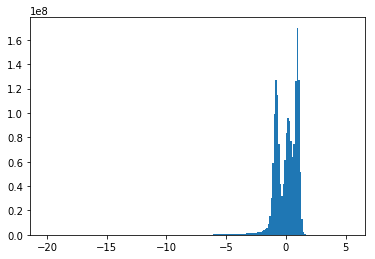

In [12]:
plt.hist(Image_RGB.reshape(-1,),200)
plt.show()

In [14]:
Image_RGB /=2

In [15]:
label = np_utils.to_categorical(Class, 3)
data = Image_RGB
index = [i for i in range(len(data))]
#random.shuffle(index)
train_data = data[index]
train_label = label[index]
Class = Class[index]
Redshift = Redshift[index]
print('train_data.shape:',train_data.shape)
print('train_label.shape:',train_label.shape)

train_data.shape: (140976, 64, 64, 3)
train_label.shape: (140976, 3)


In [16]:
batch_size =100
latent_dim = 2
nb_epoch = 50  
epsilon_std = 0.1 
intermediate_dim =256
original_dim = 64*64

#USE = 'autoencoder'
USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,3))


x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(x)
h_1 = Dense(intermediate_dim, activation='tanh')(visual)
encoded = Dense(latent_dim, activation='relu')(h_1)

z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

if USE == 'vae':
    h_3 = Dense(intermediate_dim,activation='tanh')(z)#for VAE

if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation='tanh')(encoded)#for AE
    
    
h_4 = Dense(20*2*2,activation='relu')(h_3)
h_5 = Reshape((2,2,20))(h_4)


x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')


def vae_loss(x, decoded):
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 1*kl_loss  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)
if USE == 'vae':
    vae = Model(inputs=input_img, outputs=decoded) 
    vae.compile(optimizer='rmsprop', loss=vae_loss) 

In [17]:
vae.fit(train_data[:12000], train_data[:12000],
        shuffle=True,
        epochs=50,
        batch_size=batch_size,
        validation_data=(train_data[12000:14100],train_data[12000:14100]),callbacks=[EarlyStopping])

Train on 12000 samples, validate on 2100 samples
Epoch 1/50
12000/12000 [==============================] - 10s - loss: -9553.2680 - val_loss: -10440.4278
Epoch 2/50
12000/12000 [==============================] - 8s - loss: -10154.8578 - val_loss: -10544.7305
Epoch 3/50
12000/12000 [==============================] - 8s - loss: -10297.0962 - val_loss: -10478.3928
Epoch 4/50
12000/12000 [==============================] - 8s - loss: -10308.0590 - val_loss: -10536.1864
Epoch 5/50
12000/12000 [==============================] - 8s - loss: -10305.6998 - val_loss: -10548.3490
Epoch 6/50
12000/12000 [==============================] - 8s - loss: -10299.8960 - val_loss: -10547.6176
Epoch 7/50
12000/12000 [==============================] - 8s - loss: -10327.5492 - val_loss: -10250.6093A: 0s -
Epoch 8/50
12000/12000 [==============================] - 8s - loss: -10320.0704 - val_loss: -10573.9090
Epoch 9/50
12000/12000 [==============================] - 8s - loss: -10341.6737 - val_loss: -10537.8516

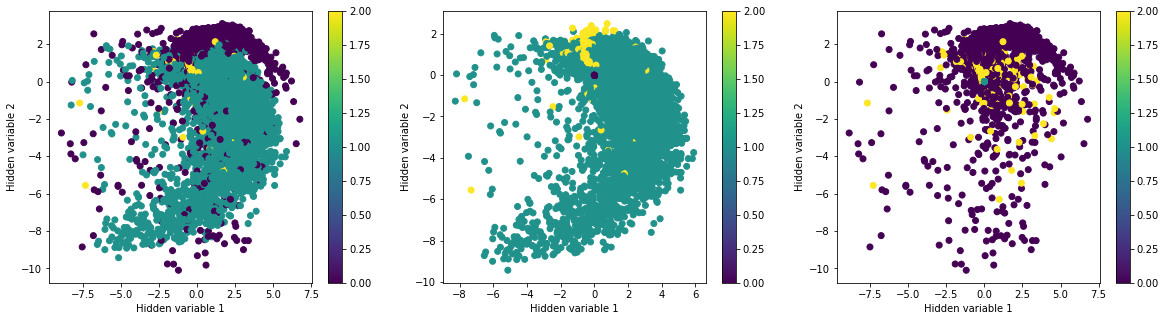

In [18]:
lower_lim = 0
upper_lim = 50000

label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)

x_vis_1 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_1[label_value[lower_lim:upper_lim]<1]=0

x_vis_2 = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)  
x_vis_2[label_value[lower_lim:upper_lim]==1]=0

plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

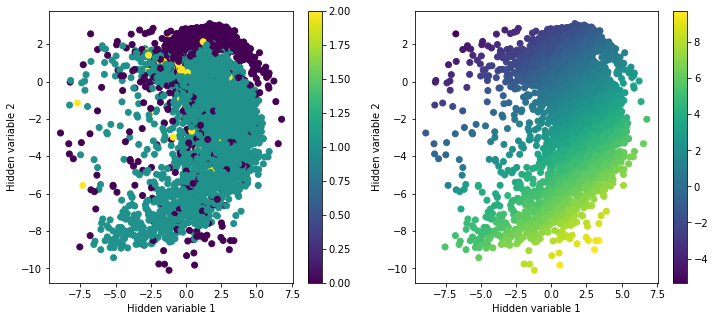

In [19]:
lower_lim = 0
upper_lim = 50000


vis = Model(input_img, z_mean)
# display a 2D plot of the digit classes in the latent space
x_vis = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)
n_neighbors = 10
n_components = 1
isomap = manifold.Isomap(n_neighbors, n_components)
hid_pred = vis.predict(train_data[lower_lim:upper_lim], batch_size=batch_size)
Y_pred = isomap.fit_transform(hid_pred)


plt.figure(figsize=(12, 5))

ax = plt.subplot(1,2,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[lower_lim:upper_lim])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,2,2)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Y_pred)
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()

7500
AUC: 0.889563389754


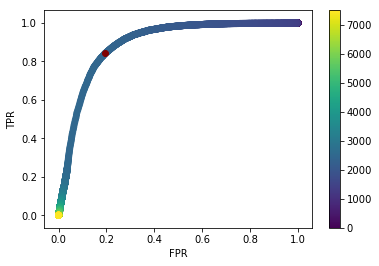

In [20]:
#Y_pred = -Y_pred
thr_min = -5
thr_max = 10
test_accuracy = 0.002
test_range = int((thr_max - thr_min)/test_accuracy)
print(test_range)
FP = []
TP = []
TN = []
FN = []
TA = np.ones((Y_pred.shape[0],))
TA[Class[lower_lim:upper_lim] ==0 ] = 0
TA[Class[lower_lim:upper_lim] ==2 ] = 0

for i in range(test_range):
    FP_temp = np.zeros((Y_pred.shape[0]))
    TP_temp = np.zeros((Y_pred.shape[0]))
    TN_temp = np.zeros((Y_pred.shape[0]))
    FN_temp = np.zeros((Y_pred.shape[0]))
    LA = np.zeros((Y_pred.shape[0],))
    thr_now = thr_min+ i*test_accuracy
    LA[Y_pred[:,0] > thr_now] = 1
    for j in range(Y_pred.shape[0]):
        if LA[j]==0:
            if TA[j]==1:
                FN_temp[j] = 1
            else:
                TN_temp[j] = 1
        else:
            if TA[j] == 1:
                TP_temp[j] = 1
            else:
                FP_temp[j] = 1
    FP.append(FP_temp)
    TP.append(TP_temp)
    TN.append(TN_temp)
    FN.append(FN_temp)
    
TPR = np.zeros((test_range,))
FPR = np.zeros((test_range,))
TPR = np.sum(TP,axis=-1)/(np.sum(TP,axis=-1)+np.sum(FN,axis=-1))
FPR = np.sum(FP,axis=-1)/(np.sum(FP,axis=-1)+np.sum(TN,axis=-1))

plt.scatter(FPR,TPR,c=[i for i in range(test_range)])

plt.colorbar()
plt.scatter(FPR[np.argmin((TPR-1)**2 + FPR**2)],TPR[np.argmin((TPR-1)**2 + FPR**2)],c=0,cmap='OrRd_r')
plt.xlabel('FPR')
plt.ylabel('TPR')
#argmax, OrRed

print("AUC:",metrics.auc(FPR, TPR))